In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
from perm_test import pw_perm_kruskal_test
from statsmodels.stats.multitest import multipletests

## Import data

In [2]:
#import 16S Aitchison distance matrix 
amp = pd.read_csv('../data/SMDS_aitchison_distance_matrix.tsv', sep='\t', index_col=0)
# import metaphlan2 Aitchison distance matrix 
mp = pd.read_csv('../data/SMDS_metaphlan2_species_noblanks_aitchison_dm.tsv', sep='\t', index_col=0)
# import humann2 Aitchison distance matrix 
h2 = pd.read_csv('../data/SMDS_humann2_pathway_aitchison_dm.tsv', sep='\t', index_col=0)

## Reformat distance matrices

### 16S distances

In [3]:
#melt distance matrix and convert to pandas dataframe 
meltaitch = amp.unstack()
df = pd.DataFrame(meltaitch)
df.reset_index(inplace=True)
df.columns=['col1','col2','distance']

#remove self-self samples
df = df[df['col1']!=df['col2']]
#remove duplicates
df['check_string'] = df.apply(lambda row: ''.join(sorted([row['col1'], row['col2']])), axis=1)
amp = df.drop_duplicates('check_string')

In [4]:
#split sample names to break down comparisons, and merge into one dataframe
df1 = df.col1.str.split('.',expand=True)
df1.columns=['samp','tx']

df2 = df.col2.str.split('.',expand=True)
df2.columns=['samp2','tx2']

dff = pd.concat([df1, df2, df], axis=1)

# add in HostSubject ID
dff['participant1'] = dff['samp'].str[0:1]
dff['participant2'] = dff['samp2'].str[0:1]

# add in timepoint 
dff['timepoint1'] = dff['samp'].str[1:]
dff['timepoint2'] = dff['samp2'].str[1:]

#only look at lyPMA samples to compare to metaphlan and humann2 output
dff = dff[(dff['tx']=='lyPMA')&(dff['tx2']=='lyPMA')]
ampl = dff.copy()
ampl.head()

,samp,tx,samp2,tx2,col1,col2,distance,check_string,participant1,participant2,timepoint1,timepoint2
1,A1,lyPMA,A4,lyPMA,A1.lyPMA,A4.lyPMA,34.013113,A1.lyPMAA4.lyPMA,A,A,1,4
3,A1,lyPMA,A2,lyPMA,A1.lyPMA,A2.lyPMA,29.424909,A1.lyPMAA2.lyPMA,A,A,1,2
5,A1,lyPMA,A3,lyPMA,A1.lyPMA,A3.lyPMA,22.638635,A1.lyPMAA3.lyPMA,A,A,1,3
8,A1,lyPMA,A5,lyPMA,A1.lyPMA,A5.lyPMA,21.049421,A1.lyPMAA5.lyPMA,A,A,1,5
10,A1,lyPMA,A6,lyPMA,A1.lyPMA,A6.lyPMA,22.287257,A1.lyPMAA6.lyPMA,A,A,1,6


### metaphlan2 distances

In [5]:
#melt distance matrix and convert to pandas dataframe 
meltaitch = mp.unstack()
df = pd.DataFrame(meltaitch)
df.reset_index(inplace=True)
df.columns=['sample1','sample2','distance']
# add in appropriate name
df['col1'] = df['sample1'].str[:-69]
df['col2'] = df['sample2'].str[:-69]
df.head()
#remove self-self samples
df = df[df['col1']!=df['col2']]
#remove duplicates
df['check_string'] = df.apply(lambda row: ''.join(sorted([row['col1'], row['col2']])), axis=1)
df = df.drop_duplicates('check_string')

In [6]:
#split sample names to break down comparisons, and merge into one dataframe
df1 = df.col1.str.split('_',expand=True)
df1.replace('lyPMA2','lyPMA', inplace=True)
df1.columns=['samp','tx']

df2 = df.col2.str.split('_',expand=True)
df2.replace('lyPMA2','lyPMA', inplace=True)
df2.columns=['samp2','tx2']

dff = pd.concat([df, df1, df2], axis=1)
# get rid of columns you don't need anymore
dff.drop(['sample1','sample2'], axis=1, inplace=True)

#add in HostSubject ID
dff['participant1'] = dff['samp'].str[0:1]
dff['participant2'] = dff['samp2'].str[0:1]
# add in timepoint 
dff['timepoint1'] = dff['samp'].str[1:]
dff['timepoint2'] = dff['samp2'].str[1:]

mep = dff.copy()
mep.head()

,distance,col1,col2,check_string,samp,tx,samp2,tx2,participant1,participant2,timepoint1,timepoint2
1,4.409680,A1_lyPMA,A2_lyPMA,A1_lyPMAA2_lyPMA,A1,lyPMA,A2,lyPMA,A,A,1,2
2,3.374401,A1_lyPMA,A3_lyPMA,A1_lyPMAA3_lyPMA,A1,lyPMA,A3,lyPMA,A,A,1,3
3,4.459073,A1_lyPMA,A5_lyPMA,A1_lyPMAA5_lyPMA,A1,lyPMA,A5,lyPMA,A,A,1,5
4,4.126941,A1_lyPMA,A6_lyPMA,A1_lyPMAA6_lyPMA,A1,lyPMA,A6,lyPMA,A,A,1,6
5,3.932718,A1_lyPMA,A7_lyPMA,A1_lyPMAA7_lyPMA,A1,lyPMA,A7,lyPMA,A,A,1,7


### humann2 distances

In [7]:
#melt distance matrix and convert to pandas dataframe 
meltaitch = h2.unstack()
df = pd.DataFrame(meltaitch)
df.reset_index(inplace=True)
df.columns=['col1','col2','distance']
#remove self-self samples
df = df[df['col1']!=df['col2']]
#remove duplicates
df['check_string'] = df.apply(lambda row: ''.join(sorted([row['col1'], row['col2']])), axis=1)
df = df.drop_duplicates('check_string')

In [8]:
# add in participant ID 
df['participant1'] = df['col1'].str[0:1]
df['participant2'] = df['col2'].str[0:1]
# add in timepoint 
df['timepoint1'] = df['col1'].str[1:]
df['timepoint2'] = df['col2'].str[1:]

hu2 = df.copy()
hu2.head()

,col1,col2,distance,check_string,participant1,participant2,timepoint1,timepoint2
1,C8,I9,53.088736,C8I9,C,I,8,9
2,C8,H2,56.529445,C8H2,C,H,8,2
3,C8,I6,54.684440,C8I6,C,I,8,6
4,C8,C2,43.183710,C2C8,C,C,8,2
5,C8,D8,50.012928,C8D8,C,D,8,8


## Apply function to categorize distances

In [9]:
# create function to label within versus among participants distances
def f(row):
    if (row['participant1']==row['participant2']):
        val = "same_participant_different_timepoint"
    elif (row['timepoint1']==row['timepoint2']):
        val = "same_timepoint_different_participants"
    else:
        val = "something_else"
    return val

ampl['distance_cat'] = ampl.apply(f, axis=1)
mep['distance_cat'] = mep.apply(f, axis=1)
hu2['distance_cat'] = hu2.apply(f, axis=1)

## Plot Figure S3

Text(0.5, 1, 'HUMAnN2')

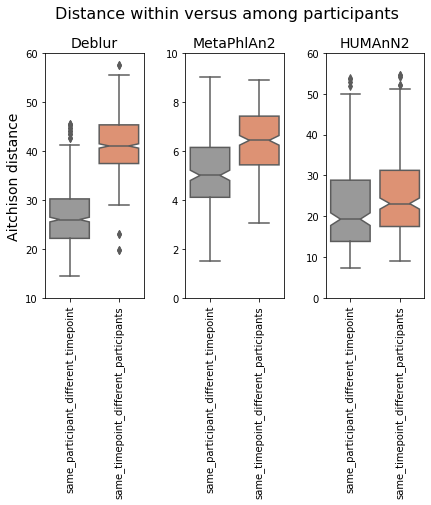

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Distance within versus among participants', y=1.11, fontsize=16)
fig.tight_layout()
# set palette
pal = {'same_participant_different_timepoint':'#999999','same_timepoint_different_participants':'#ef8a62'}
order = ['same_participant_different_timepoint', 'same_timepoint_different_participants']
# plot boxplots
sns.boxplot(x='distance_cat', y='distance',data=ampl, palette=pal, notch=True, ax=ax1, order=order)
sns.boxplot(x='distance_cat', y='distance',data=mep, palette=pal, notch=True, ax=ax2, order=order)
sns.boxplot(x='distance_cat', y='distance',data=hu2, palette=pal, notch=True, ax=ax3, order=order)
# rotated x-label
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 90)
# set y-axis limits
ax1.set_ylim(10,60)
ax2.set_ylim(0,10)
ax3.set_ylim(0,60)
# set y-label
ax1.set_ylabel('Aitchison distance', fontsize=14)
ax2.set_ylabel('')
ax3.set_ylabel('')
# set y-label
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
# set y-label
ax1.set_title('Deblur', fontsize=14)
ax2.set_title('MetaPhlAn2', fontsize=14)
ax3.set_title('HUMAnN2', fontsize=14)

## Stats time

In [17]:
## Include only distances from either
# the same participant over time
# or different participants at the same time
ampl = ampl[ampl['distance_cat']!='something_else']
mep = mep[mep['distance_cat']!='something_else']
hu2 = hu2[hu2['distance_cat']!='something_else']

In [16]:
# Run bootstrapped Kruskal-Wallis test 
# on 16S rRNA gene amplicon sequencing dataset
result = pw_perm_kruskal_test(ampl['distance'], ampl['distance_cat'])
print(result)

                                  Group1  \
0  same_timepoint_different_participants   

                                 Group2   Statistic      Pval  
0  same_participant_different_timepoint  921.223006  0.000999  


In [18]:
# Run bootstrapped Kruskal-Wallis test 
# on shotgun metagenomic sequencing dataset processed with
# MetaPhlAn2 to identify species relative abundance
result = pw_perm_kruskal_test(mep['distance'], mep['distance_cat'])
print(result)

                                  Group1  \
0  same_timepoint_different_participants   

                                 Group2  Statistic      Pval  
0  same_participant_different_timepoint   85.27785  0.000999  


In [20]:
# Run bootstrapped Kruskal-Wallis test 
# on shotgun metagenomic sequencing dataset processed with
# HUMAnN2 to identify functional pathway relative abundance
result = pw_perm_kruskal_test(hu2['distance'], hu2['distance_cat'])
print(result)

                                  Group1  \
0  same_timepoint_different_participants   

                                 Group2  Statistic      Pval  
0  same_participant_different_timepoint  13.375795  0.000999  
